In [62]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, csc_matrix, linalg as LA
import time

# 1. Construction the matrix X

In [2]:
np.set_printoptions(suppress=1)

In [19]:
def construct_X(M, angles, Np=None):
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
        if Np % 2 == 0:
            Np += 1
    
    D = M**2
    No = len(angles)
    N = No * Np
    
    # coordinate matrix
    C = np.mgrid[M-1:-1:-1, :M].astype(np.float64).reshape(2, -1)
    center = M / 2
    C += 0.5 - center
        
    # convert angles from degrees to radians
    angles = np.unwrap(np.deg2rad(angles))
    
    # matrix of normal vectors for rays
    n = np.column_stack([np.sin(angles), np.cos(angles)])
    
    # position of sensor 0 to sensor coordinate system
    s0 = Np / 2 - 0.5
    
    # projections if pixel onto sensor
    # first dim: angles, 2. dim: j
    p = np.dot(n, C) + s0
    
    # lists for building of sparse matrix
    weights, i_ind, j_ind = [], [], []
    
    # find weights for every angle
    for i_o, pixels in enumerate(p):
        pixel_floor = np.floor(pixels).astype(int)
        alpha = pixels - pixel_floor
        sensor_ind = np.concatenate((pixel_floor, pixel_floor+1))
        weight = np.concatenate((1-alpha, alpha))
        mask = np.logical_and(sensor_ind >= 0, sensor_ind < Np)
        
        weights += list(weight[mask])
        i_ind += list(sensor_ind[mask] + i_o * Np)
        j_ind += list(np.nonzero(mask)[0] % D)
    
    return coo_matrix((weights, (i_ind, j_ind)), shape=(N, D), dtype=np.float32).asformat('csc')

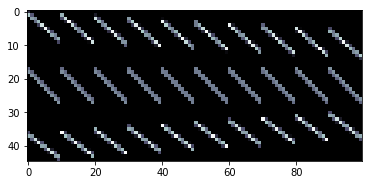

In [10]:
X = construct_X(10, [-33, 1, 42])
X_dense = X.todense()
plt.imshow(X_dense, cmap='bone')

In [4]:
# check if computed matrix is equal to example
X_ex = np.load('hs_tomography/X_example.npy')
assert(np.all(X_ex == X_dense))

# 2. Recovering the image

In [ ]:
# alphas = np.load('hs_tomography/alphas_77.npy')
# response = np.load('hs_tomography/y_77.npy')
# M = 77
# Np = 109

alphas = np.load('hs_tomography/alphas_195.npy')
response = np.load('hs_tomography/y_195.npy')
M = 195
Np = 275

def image(alphas, response, M, Np, tol=1e-4):
    t0 = time.time()
    X = construct_X(M, alphas, Np)
    t1 = time.time()
    print(f"Sparsity of X: {X.nnz / np.product(X.shape)}, Time to construct X: {t1-t0:.2f}s")
    beta = LA.lsqr(X, response, atol=tol, btol=tol)[0]
    t2 = time.time()
    print(f"Solved for image in {t2-t1:.2f}s with tolerance {tol}, total time {t2-t0:.2f}")
    return beta.reshape(M,M)

In [66]:
beta = image(alphas, response, M, Np)

Sparsity of X: 0.007272716587714439, Time to construct: 24.05s
Solved for image in 11.962331056594849s with tolerance 0.00, total time 36.01


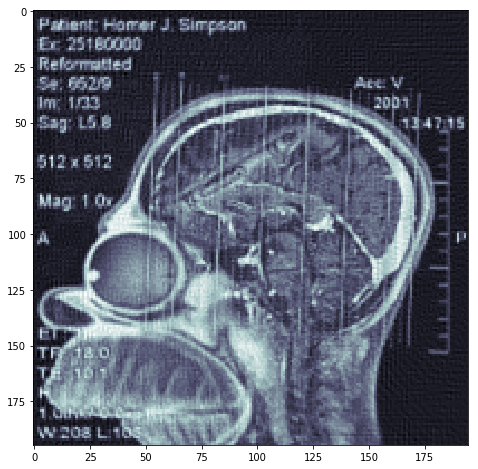

In [67]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(beta, cmap='bone')

# 3. Minimizing the radiation dose

In [88]:
images = []
for i in range(9):
    images.append(image(alphas[::i+1], response.reshape(-1, Np)[::i+1].reshape(-1), 195, 275))

Sparsity of X: 0.007272716587714439, Time to construct: 26.26s
Solved for image in 11.37s with tolerance 0.0001, total time 37.63
Sparsity of X: 0.007272718772205952, Time to construct: 9.78s
Solved for image in 5.19s with tolerance 0.0001, total time 14.97
Sparsity of X: 0.0072727208973362815, Time to construct: 7.06s
Solved for image in 3.46s with tolerance 0.0001, total time 10.52
Sparsity of X: 0.007272718772205952, Time to construct: 5.24s
Solved for image in 2.18s with tolerance 0.0001, total time 7.42
Sparsity of X: 0.007272716647075622, Time to construct: 4.14s
Solved for image in 2.15s with tolerance 0.0001, total time 6.29
Sparsity of X: 0.007272727272727273, Time to construct: 3.26s
Solved for image in 1.83s with tolerance 0.0001, total time 5.10
Sparsity of X: 0.007272727272727273, Time to construct: 2.99s
Solved for image in 1.35s with tolerance 0.0001, total time 4.34
Sparsity of X: 0.007272727272727273, Time to construct: 2.55s
Solved for image in 1.02s with tolerance 0.

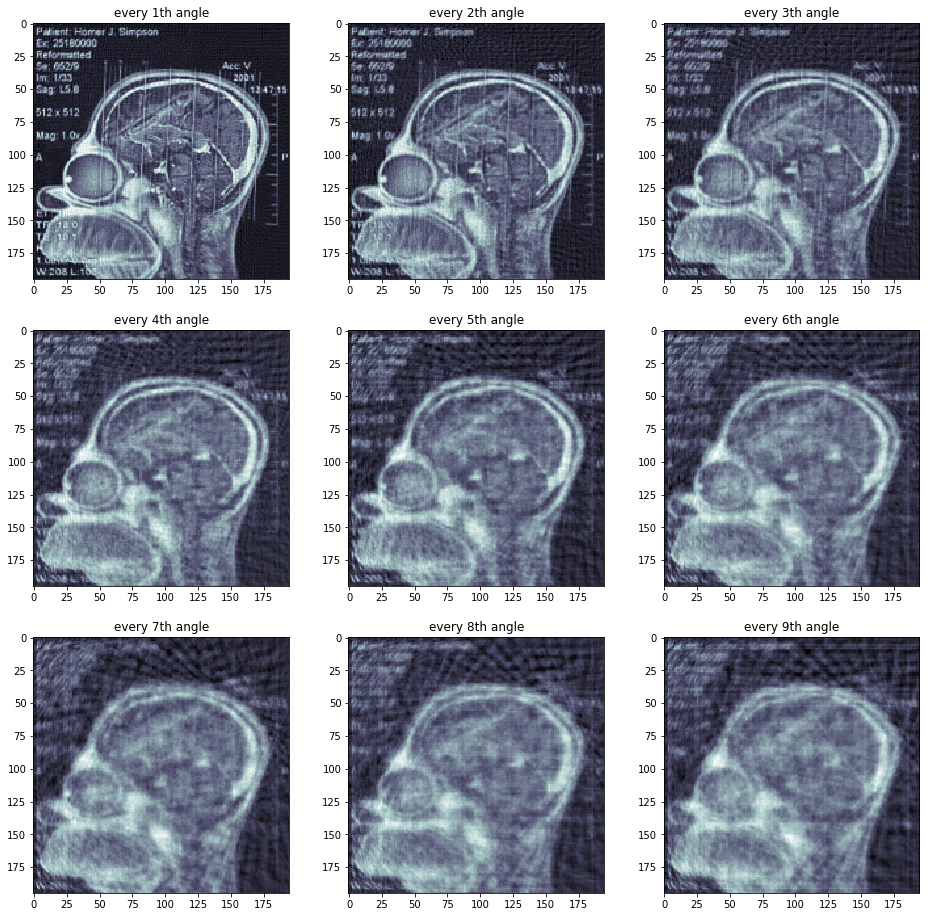

In [91]:
fig, axes = plt.subplots(3,3, figsize=(16,16))
for i, (img, ax) in enumerate(zip(images, axes.flatten())):
    ax.imshow(img, cmap='bone')
    ax.set_title(f"every {i+1}th angle")

Sparsity of X: 0.007272716647075622, Time to construct: 9.90s
Solved for image in 8.87s with tolerance 0.0001, total time 18.77


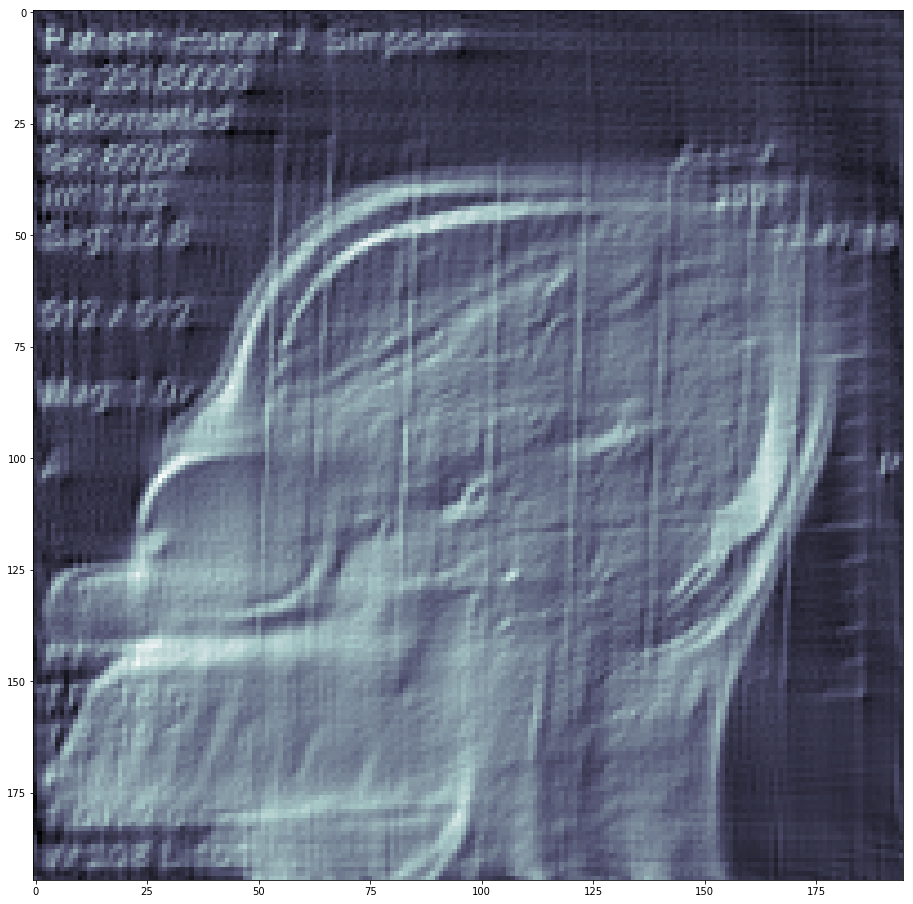

In [102]:
fig, ax = plt.subplots(figsize=(16,16))
img1 = image(alphas[:90], response.reshape(-1, Np)[:90].reshape(-1), 195, 275)
ax.imshow(img1, cmap='bone')